#Connect drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Vocab

In [2]:
import torch
from torch.nn import functional

class Vocab:
    def __init__(self, paths):
        self.chars = None
        self.image_paths = []
        self.labels = []
        self.load_dataset(paths)

    def load_dataset(self, paths):
        if isinstance(paths, str):
            paths = [paths]

        for path in paths:
            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) != 2:
                        continue
                    img_path, label = parts
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        print(f"Total {len(self.image_paths)} images loaded from {len(paths)} file(s)")

    def create_vocab(self):
        letters = "".join(self.labels)
        unique_chars = sorted(set(letters))

        self.chars = "".join(unique_chars)

        self.char_2_idx = {char: idx + 2 for idx, char in enumerate(self.chars)}
        self.blank_index = 1  # index cho CTC blank
        self.idx_2_char = {idx: char for char, idx in self.char_2_idx.items()}

        print(f"Vocab size (with blank): {len(self.chars) + 1}")
        print(f"char_2_idx: {self.char_2_idx}")

    def encode(self, input_sequence):
        max_label_len = max(len(label) for label in self.labels)
        encoded = torch.tensor(
            [self.char_2_idx.get(char, 0) for char in input_sequence], dtype=torch.long  #  -> 0 (pad)
        )
        label_len = len(encoded)
        lengths = torch.tensor(label_len, dtype=torch.long)
        padded = functional.pad(encoded, (0, max_label_len - label_len))
        return padded, lengths

    def decode(self, encode_sequences):
        decode_sequences = []

        for seq in encode_sequences:
            decode_label = []
            prev_token = None
            if isinstance(seq, torch.Tensor):
                seq = seq.tolist()

            for token in seq:
                if token != self.blank_index and token != 0 and token != prev_token:
                    char = self.idx_2_char.get(token, '')
                    decode_label.append(char)
                prev_token = token
            decode_sequences.append(''.join(decode_label))
        return decode_sequences

    def idx_2_labels(self, labels):
        idx_2_labels = []
        for label in labels:
            if isinstance(label, torch.Tensor):
                label = label.tolist()
            chars = [self.idx_2_char.get(idx, '') for idx in label if idx != 0]
            idx_2_labels.append(''.join(chars))
        return idx_2_labels

vocab = Vocab([
    "/content/drive/MyDrive/scene-text-ocr/train.txt",
    "/content/drive/MyDrive/scene-text-ocr/val.txt",
    "/content/drive/MyDrive/scene-text-ocr/test.txt"
])
vocab.create_vocab()


Total 1088 images loaded from 3 file(s)
Vocab size (with blank): 37
char_2_idx: {'0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


#Dataset

In [3]:
from PIL import Image
from torch.utils.data import Dataset

class OCRDataSet(Dataset):
    def __init__(self, mode = 'train', label_encoder = None, transform= None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_encoder = label_encoder
        if mode == 'train':
            path = "/content/drive/MyDrive/scene-text-ocr/train.txt"
        elif mode == 'val':
            path = "/content/drive/MyDrive/scene-text-ocr/val.txt"
        elif mode == 'test':
            path = "/content/drive/MyDrive/scene-text-ocr/test.txt"
        else:
            raise NotImplementedError

        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                label = line.strip().split('\t')[1]
                img_path = line.strip().split('\t')[0]
                self.image_paths.append(img_path)
                self.labels.append(label)


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(os.path.join(image_path)).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(label)
            return image, encoded_label, label_len
        else:
            exit(-1)

if __name__ == '__main__':
    vocab = Vocab([
        "/content/drive/MyDrive/scene-text-ocr/train.txt",
        "/content/drive/MyDrive/scene-text-ocr/val.txt",
        "/content/drive/MyDrive/scene-text-ocr/test.txt"
    ])
    vocab.create_vocab()
    hw = OCRDataSet(mode = 'train', label_encoder = vocab.encode)


Total 1088 images loaded from 3 file(s)
Vocab size (with blank): 37
char_2_idx: {'0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


#Backbone

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNet34Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base_model = resnet34(pretrained=pretrained)

        old_conv1 = base_model.conv1

        new_conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv1.out_channels,
            kernel_size=old_conv1.kernel_size,
            stride=old_conv1.stride,
            padding=old_conv1.padding,
            bias=old_conv1.bias is not None,
        )

        if pretrained:
            with torch.no_grad():
                new_conv1.weight = nn.Parameter(old_conv1.weight.mean(dim=1, keepdim=True))

        base_model.conv1 = new_conv1

        self.feature_extractor = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
        )

        self.pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.feature_extractor(x)  # (B, 512, H', W')
        x = self.pool(x)               # (B, 512, 1, W)
        return x


#Sequence head

In [5]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            bidirectional=True,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2),
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # (B, W, C, 1)
        x = x.view(x.size(0), x.size(1), -1)  # (B, W, 768)
        x, _ = self.lstm(x)  # (B, W, 2*hidden)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # (W, B, Class)
        return x


#Model

In [6]:
import torch
import torch.nn as nn

class OCRModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.3, pretrained_backbone=True):
        super(OCRModel, self).__init__()
        self.backbone = ResNet34Backbone(pretrained=pretrained_backbone)
        self.lstm = BiLSTM(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            n_layers=n_layers,
            dropout=dropout,
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.lstm(x)
        return x

if __name__ == '__main__':
    model = OCRModel(vocab_size=38, hidden_size=512, n_layers=2)
    dummy_input = torch.randn(1, 1, 100, 420)  # (B, C, H, W)
    output = model(dummy_input)
    print("Final output shape:", output.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final output shape: torch.Size([14, 1, 38])


# Test

In [7]:
!pip install jiwer

In [8]:
from jiwer import cer

def calculate_cer(preds, target):
    total_cer = 0
    for pred, target in zip(preds, target):
        total_cer += cer(target, pred)
    return total_cer / len(preds)


In [9]:
save_path = "/content/drive/MyDrive/checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel(
    vocab_size=38,
    hidden_size=512,
    n_layers=2,
)
model.to(device)

OCRModel(
  (backbone): ResNet34Backbone(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [10]:
from torchvision import transforms

test_transform = transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

from torch.utils.data import DataLoader

test_dataset = OCRDataSet(
    mode = 'test',
    label_encoder = vocab.encode,
    transform = test_transform
)

batch_size = 32

loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [11]:
ctc_loss = nn.CTCLoss(blank=1, zero_infinity=True)

## Greedy search

In [18]:
import torch
from tqdm import tqdm

def evaluate_model(model, data_loader, device, criterion, vocab_util, epoch=None):
    model.eval()
    losses = []
    all_preds, all_targets = [], []
    correct_count = 0

    pbar = tqdm(data_loader, desc=f"Eval Epoch {epoch}" if epoch is not None else "Evaluation", leave=False)
    with torch.no_grad():
        for inputs, encoded_labels, labels_len in pbar:
            inputs = inputs.to(device)
            encoded_labels = encoded_labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)  # (T, B, C)
            logit_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, encoded_labels, logit_lens, labels_len)
            losses.append(loss.item())

            pred_labels = torch.argmax(outputs, dim=2).permute(1, 0)  # (B, T)
            pred_texts = vocab_util.decode(pred_labels)
            target_texts = vocab_util.idx_2_labels(encoded_labels)

            all_preds.extend(pred_texts)
            all_targets.extend(target_texts)

            for pred, target in zip(pred_texts, target_texts):
                if pred == target:
                    correct_count += 1

            batch_cer = calculate_cer(pred_texts, target_texts)
            pbar.set_postfix(loss=loss.item(), cer=batch_cer)

    avg_loss = sum(losses) / len(losses)
    final_cer = calculate_cer(all_preds, all_targets)
    accuracy = correct_count / len(all_preds) if all_preds else 0.0

    return avg_loss, final_cer, accuracy


In [19]:
evaluate_model(model, loader, device, ctc_loss, vocab)

(1.1792320907115936, 0.2317024642024642, 0.5454545454545454)

## Beam search

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import math

def log_sum_exp(a, b):
    if a == -float('inf'):
        return b
    if b == -float('inf'):
        return a
    return max(a, b) + math.log1p(math.exp(-abs(a - b)))

def beam_search_decode(log_probs, beam_width=5, blank_index=1):
    T, B, C = log_probs.size()
    log_probs = log_probs.cpu()
    final_results = []

    for b in range(B):
        beams = [([], 0.0)]
        for t in range(T):
            new_beams = {}
            for prefix, score in beams:
                for c in range(C):
                    p = log_probs[t, b, c].item()
                    new_prefix = prefix + [c]

                    if len(prefix) > 0 and c == prefix[-1]:
                        if c == blank_index:
                            key = tuple(prefix)
                            new_beams[key] = log_sum_exp(new_beams.get(key, -float('inf')), score + p)
                        else:
                            key = tuple(new_prefix)
                            new_beams[key] = log_sum_exp(new_beams.get(key, -float('inf')), score + p)
                    else:
                        key = tuple(new_prefix)
                        new_beams[key] = log_sum_exp(new_beams.get(key, -float('inf')), score + p)

            beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
            beams = [(list(k), v) for k, v in beams]

        best_seq = beams[0][0]
        final_results.append(best_seq)

    return final_results

def calculate_cer(preds, targets):
    import editdistance
    total_dist = 0
    total_len = 0
    for p, t in zip(preds, targets):
        total_dist += editdistance.eval(p, t)
        total_len += len(t)
    return total_dist / total_len if total_len > 0 else 0.0

def calculate_acc(preds, targets):
    correct = sum(p == t for p, t in zip(preds, targets))
    return correct / len(targets) if targets else 0.0

def evaluate_model(model, data_loader, device, criterion, vocab_util, epoch=None, beam_width=10):
    model.eval()
    losses = []
    all_preds, all_targets = [], []

    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f"Eval Epoch {epoch}" if epoch else "Evaluation", leave=False)
        for images, encoded_labels, labels_len in pbar:
            images = images.to(device)
            encoded_labels = encoded_labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(images)  # (T, B, C)
            logit_lens = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs, encoded_labels, logit_lens, labels_len)
            losses.append(loss.item())

            log_probs = F.log_softmax(outputs, dim=2)
            beam_decoded = beam_search_decode(log_probs, beam_width=beam_width, blank_index=1)

            preds = vocab_util.decode(beam_decoded)
            targets = vocab_util.idx_2_labels(encoded_labels)

            all_preds.extend(preds)
            all_targets.extend(targets)

            cer = calculate_cer(preds, targets)
            acc = calculate_acc(preds, targets)
            pbar.set_postfix(loss=loss.item(), cer=cer, acc=acc)

    return {
        "loss": sum(losses) / len(losses),
        "cer": calculate_cer(all_preds, all_targets),
        "acc": calculate_acc(all_preds, all_targets),
    }


In [21]:
evaluate_model(model, loader, device, ctc_loss, vocab)

{'loss': 1.1792320907115936,
 'cer': 0.18136439267886856,
 'acc': 0.5454545454545454}

#Upload

FileUpload(value={}, accept='image/*', description='Upload')

tensor([[ 1, 30,  1, 26, 17,  1, 31, 34,  1, 12, 12, 29,  1, 16]],
       device='cuda:0')


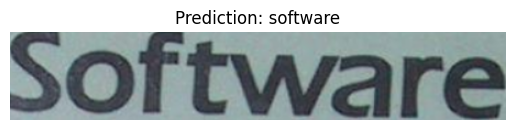

In [17]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os


# Load best model
checkpoint = torch.load(os.path.join(save_path, "best_model.pt"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image_tensor = test_transform(image).unsqueeze(0).to(device)  # (1, C, H, W)

    with torch.no_grad():
        output = model(image_tensor)  # (T, B, C)
        pred_labels = torch.argmax(output, dim=2).permute(1, 0)  # (B=1, T)
        print(pred_labels)
        pred_texts = vocab.decode(pred_labels)

    return pred_texts[0]

def on_upload_change(change):
    if uploader.value:
        uploaded_file = next(iter(uploader.value.values()))
        img_data = uploaded_file['content']
        file_path = "uploaded_image.jpg"
        with open(file_path, "wb") as f:
            f.write(img_data)

        pred = predict_image(file_path)
        img = Image.open(file_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {pred}")
        plt.show()

uploader.observe(on_upload_change, names='value')
